In [202]:
import sys 
if '..' not in sys.path:
    sys.path.append('../')
from utils import *
data_dict = load_data(verbose=True)

CONTENTS OF HDF5 FILE:
pose
	 ekf_ori, tango_ori, tango_pos
raw
	 imu
		 acce, game_rv, gps, gravity, gyro, gyro_uncalib, linacce, magnet, magnetic_rv, pressure, rv, step, wifi_address, wifi_values
	 tango
		 acce, game_rv, gps, gravity, gyro, gyro_uncalib, linacce, magnet, magnetic_rv, pressure, rv, step, tango_adf_pose, tango_pose, wifi_address, wifi_values
synced
	 acce, game_rv, grav, gyro, gyro_uncalib, linacce, magnet, rv, time


In [203]:
w = data_dict['synced/gyro']
N = 20000
# 100 time steps
q_gt = data_dict['pose/tango_ori'][:N]
dt = data_dict['synced/time'][1] - data_dict['synced/time'][0]
q_pred = np.zeros((N,4))
q_pred[0] = q_gt[0]
factor= .0025                                # has been set arbitrarily
for i in range(1,N):
    q_pred[i] = Theta(w[i]*factor, dt=dt)@q_pred[i-1]



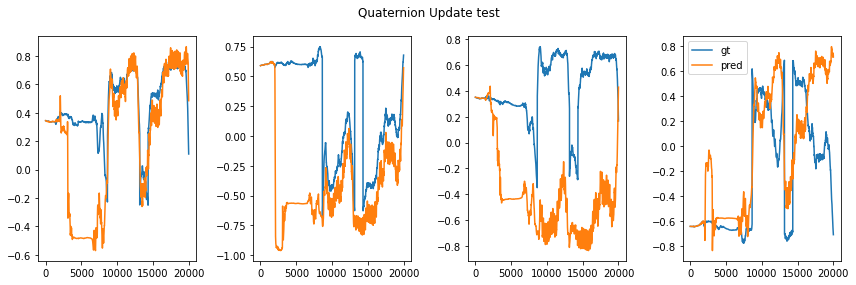

In [204]:
# plot
def plot_quat(q_gt, q_pred):
    fig, ax = plt.subplots(1, 4, figsize=(12, 4))
    ax[0].plot(q_gt[:,0],)
    ax[0].plot(q_pred[:,0],)
    ax[1].plot(q_gt[:,1],)
    ax[1].plot(q_pred[:,1],)
    ax[2].plot(q_gt[:,2],)
    ax[2].plot(q_pred[:,2],)
    ax[3].plot(q_gt[:,3],label='gt')
    ax[3].plot(q_pred[:,3],label='pred')
    ax[3].legend()
    fig.suptitle('Quaternion Update test')
    plt.tight_layout()

plot_quat(q_gt, q_pred)

## NN

In [205]:
# set up a neural network with 3 inputs and 16 outputs
# the 3 inputs are the 3 components of the angular velocity
# the 16 outputs are the 16 elements of the 4x4 matrix Theta(w)
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class Net(nn.Module):
    def __init__(self, input_size=13, output_size=16, hidden_size=16, num_layers=2):
        super(Net, self).__init__()
        self.num_layers = num_layers
        self.fc_input = nn.Linear(input_size, hidden_size)
        hidden_layers = []
        for i in range(self.num_layers):
            hidden_layers.append(nn.Linear(hidden_size, hidden_size))
        self.hidden_layers = nn.ModuleList(hidden_layers)

        self.fc_output = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        #print(x)
        x = F.relu(self.fc_input(x))
        for i in range(self.num_layers):
            x = F.relu(self.hidden_layers[i](x))
            
        x = self.fc_output(x)
        return x
    
net = Net(input_size=124, output_size=4, hidden_size=64, num_layers=10)

# number of params
num_params = sum(p.numel() for p in net.parameters() if p.requires_grad)
print('Number of parameters: %d' % num_params)

Number of parameters: 49860


In [206]:
def get_data(start=0, stop=1500, group_num=40):

    ori =data_dict['pose/tango_ori'][start:stop]  
    w = data_dict['synced/gyro'][start:stop]
    a = data_dict['synced/acce'][start:stop]
    m = data_dict['synced/magnet'][start:stop]
    #print shapes
    print('ori.shape', ori.shape, 'w.shape', w.shape, 'a.shape', a.shape, 'm.shape', m.shape)
    # every 10
    w = w[:-(w.shape[0]%group_num)] if w.shape[0]%group_num != 0 else w
    ori = ori[:-(ori.shape[0]%group_num)] if ori.shape[0]%group_num != 0 else ori

    # reshape
    w_10 = w.reshape(-1,group_num*w.shape[1])
    ori_10 = ori.reshape(-1,group_num*ori.shape[1])
    
    print('w_10.shape', w_10.shape)
    print('ori_10.shape', ori_10.shape)

    X = np.hstack([w_10, ori_10[:,:4] ])
    y = ori_10[:,-4:]  

    print(X.shape, y.shape)

    return X, y

X, y = get_data(start=0, stop=20000)


ori.shape (20000, 4) w.shape (20000, 3) a.shape (20000, 3) m.shape (20000, 3)
w_10.shape (500, 120)
ori_10.shape (500, 160)
(500, 124) (500, 4)


In [207]:
# data preparation


# train test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, shuffle=False)

# convert to torch tensors
X_train = torch.from_numpy(X_train).float()
y_train = torch.from_numpy(y_train).float()
X_test = torch.from_numpy(X_test).float()
y_test = torch.from_numpy(y_test).float()

# dataset
train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
test_dataset = torch.utils.data.TensorDataset(X_test, y_test)

# dataloader
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=128, shuffle=False)






In [211]:
# optimizer
optimizer = optim.Adam(net.parameters(), lr=0.0001)

# loss function
criterion = nn.L1Loss()

# train
num_epochs = 1000

for epoch in range(num_epochs):
    running_loss = 0.0
    for i, data in enumerate(train_loader):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print('Epoch %d, loss: %.5f' % (epoch+1, running_loss))

    # test
    with torch.no_grad():
        running_loss = 0.0
        for i, data in enumerate(test_loader):
            inputs, labels = data
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
        print('Test loss: %.5f' % running_loss)


Epoch 1, loss: 0.13023
Test loss: 0.04534


Epoch 2, loss: 0.04918
Test loss: 0.04512
Epoch 3, loss: 0.05153
Test loss: 0.04342
Epoch 4, loss: 0.05006
Test loss: 0.04531
Epoch 5, loss: 0.05327
Test loss: 0.04380
Epoch 6, loss: 0.05010
Test loss: 0.04397
Epoch 7, loss: 0.04836
Test loss: 0.04525
Epoch 8, loss: 0.05032
Test loss: 0.04512
Epoch 9, loss: 0.08457
Test loss: 0.04494
Epoch 10, loss: 0.05040
Test loss: 0.04415
Epoch 11, loss: 0.05159
Test loss: 0.04521
Epoch 12, loss: 0.05078
Test loss: 0.04488
Epoch 13, loss: 0.05053
Test loss: 0.04518
Epoch 14, loss: 0.04633
Test loss: 0.04559
Epoch 15, loss: 0.04907
Test loss: 0.04443
Epoch 16, loss: 0.05315
Test loss: 0.04498
Epoch 17, loss: 0.05129
Test loss: 0.04460
Epoch 18, loss: 0.04625
Test loss: 0.04455
Epoch 19, loss: 0.05072
Test loss: 0.04564
Epoch 20, loss: 0.04888
Test loss: 0.04429
Epoch 21, loss: 0.04982
Test loss: 0.04442
Epoch 22, loss: 0.05051
Test loss: 0.04425
Epoch 23, loss: 0.05021
Test loss: 0.04555
Epoch 24, loss: 0.04849
Test loss: 0.04509
Epoch 25, loss: 0.0

ori.shape (20000, 4) w.shape (20000, 3) a.shape (20000, 3) m.shape (20000, 3)
w_10.shape (500, 120)
ori_10.shape (500, 160)
(500, 124) (500, 4)


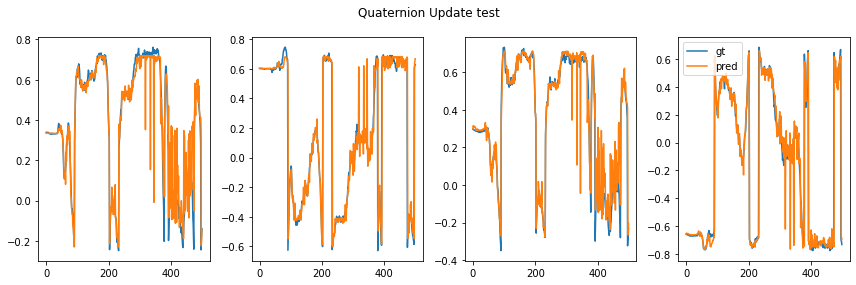

In [212]:
# testing unseen         

n_unseen = 20000
start, end = 5000, 5000+n_unseen
#start, end = 0, n_unseen


X_unseen, y_unseen = get_data(start=start, stop=end)


y_pred = []
with torch.no_grad():
    for i in range(len(X_unseen)):
        if i > 0:
            X_unseen[i, 0:4] = y_pred[i-1]
        inputs = torch.from_numpy(X_unseen[i]).float()
        outputs = net(inputs)
        y_pred.append(outputs.numpy())


y_pred = np.array(y_pred)
plot_quat(y_unseen, y_pred)


In [210]:
# so i think we might have a problem due to the fact that we have limit precision and  we are sampling very often. So the angular velocity doesnt have time to change the quaternion below the precision limit. As such we could try to only compare every 10 samples or so.